In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# Data Preparation
train_dir = "../../data/train"
validation_dir = "../../data/validation"
batch_size = 32
image_size = (224, 224)

# Reduced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,  # Reduced rotation
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,  # Reduced shifts
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 19001 images belonging to 4 classes.
Found 2427 images belonging to 4 classes.


In [3]:
# Standalone ResNet50 Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_base.trainable = False  # Freeze base model

    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet50_model(num_classes)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [4]:
# Train the ResNet50 Model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("../../models/Improved_resnet50_model_larger.keras")

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


594/594 ━━━━━━━━━━━━━━━━━━━━ 895s 1s/step - AUC: 0.7463 - accuracy: 0.4892 - loss: 1.2177 - val_AUC: 0.8459 - val_accuracy: 0.6003 - val_loss: 0.9908 - learning_rate: 3.5449e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - AUC: 0.8229 - accuracy: 0.5638 - loss: 1.0200 - val_AUC: 0.8578 - val_accuracy: 0.6172 - val_loss: 0.9051 - learning_rate: 1.0000e-08
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - AUC: 0.8255 - accuracy: 0.5734 - loss: 1.0063 - val_AUC: 0.8577 - val_accuracy: 0.6168 - val_loss: 0.9053 - learning_rate: 1.0000e-08
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - AUC: 0.8201 - accuracy: 0.5659 - loss: 1.0201 - val_AUC: 0.8582 - val_accuracy: 0.6156 - val_loss: 0.9030 - learning_rate: 1.0000e-08
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - AUC: 0.8231 - accuracy: 0.5640 - loss: 1.0136 - val_AUC: 0.8575 - val_accuracy: 0.6160 - val_loss: 0.9054 - learning_rate: 1.0000e-08
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 774s 1s/step - AUC: 0.8247

76/76 ━━━━━━━━━━━━━━━━━━━━ 72s 945ms/step - AUC: 0.8541 - accuracy: 0.6068 - loss: 0.9142
Validation Loss: 0.90
Validation Accuracy: 0.62
76/76 ━━━━━━━━━━━━━━━━━━━━ 74s 955ms/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.28      0.32      0.30       750
      2. Ekzama       0.23      0.27      0.25       508
        3. Akne       0.12      0.11      0.12       322
      4. Malign       0.34      0.28      0.31       847

       accuracy                           0.27      2427
      macro avg       0.24      0.24      0.24      2427
   weighted avg       0.27      0.27      0.27      2427

[[240 199 102 209]
 [158 135  62 153]
 [120  75  37  90]
 [325 183 105 234]]


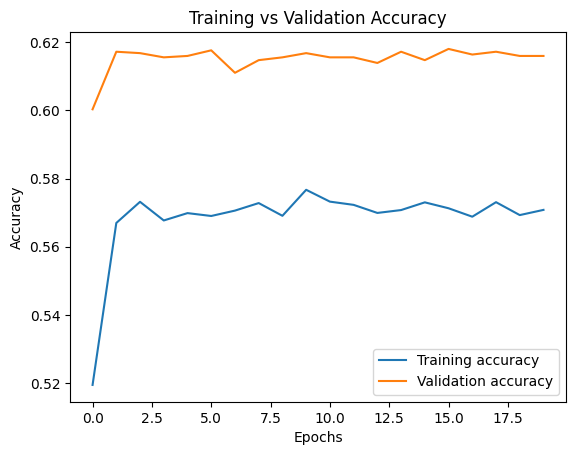

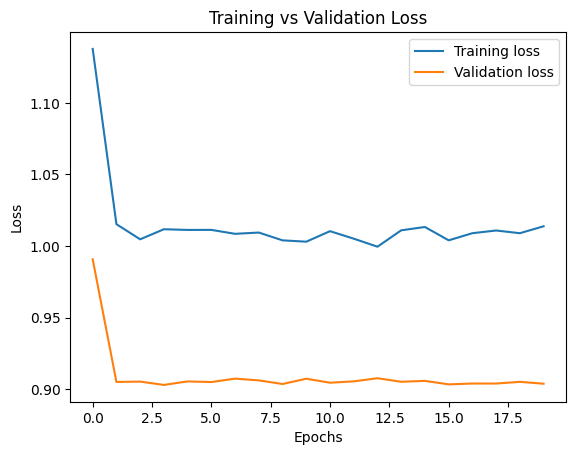

In [5]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))

# Plot training and validation curves
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

Epoch 1/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3094s 5s/step - AUC: 0.6515 - accuracy: 0.3978 - loss: 1.3147 - val_AUC: 0.5503 - val_accuracy: 0.3197 - val_loss: 1.3701 - learning_rate: 1.0000e-04
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3144s 5s/step - AUC: 0.7577 - accuracy: 0.4800 - loss: 1.1474 - val_AUC: 0.8502 - val_accuracy: 0.6321 - val_loss: 1.0005 - learning_rate: 1.0000e-04
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3275s 6s/step - AUC: 0.7823 - accuracy: 0.5005 - loss: 1.0812 - val_AUC: 0.8015 - val_accuracy: 0.5237 - val_loss: 1.0766 - learning_rate: 1.0000e-04
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3140s 5s/step - AUC: 0.7950 - accuracy: 0.5259 - loss: 1.0532 - val_AUC: 0.8746 - val_accuracy: 0.6213 - val_loss: 0.9143 - learning_rate: 1.0000e-04
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3386s 6s/step - AUC: 0.8138 - accuracy: 0.5630 - loss: 1.0140 - val_AUC: 0.8549 - val_accuracy: 0.5937 - val_loss: 0.9447 - learning_rate: 1.0000e-04
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3485s 6s/s

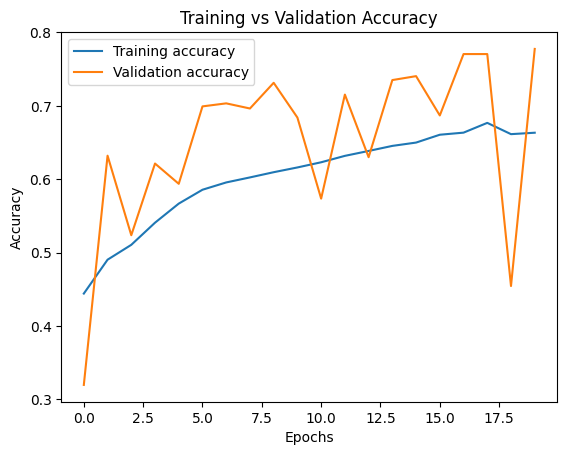

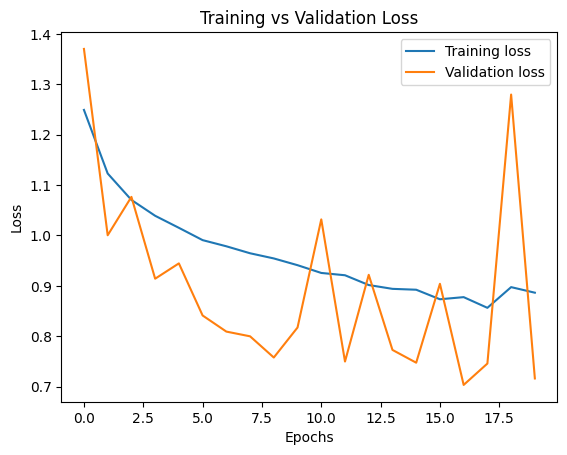

In [6]:
# Unfreeze the last few layers of the original model
for layer in model.layers[-10:]:
    layer.trainable = True  # Enable training for the last 10 layers

# Add dropout layers to the fully connected part of the model
x = model.output
x = Dropout(0.5)(x)  # Add dropout before the final dense layers
x = Dense(256, activation='relu')(x)  # Add an extra dense layer for better representation
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final output layer

# Create a new model
dropout_model = Model(inputs=model.input, outputs=predictions)

# Compile the model with a lower learning rate for fine-tuning
dropout_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']
)

# Fine-tune the model
fine_tune_history = dropout_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Save the fine-tuned model
dropout_model.save("../../models/Improved_resnet50_model_larger_fine.keras")

# Plot training results
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])

In [7]:
# Evaluate the ResNet50 Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")


76/76 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - AUC: 0.9422 - accuracy: 0.8076 - loss: 0.8321
Validation Loss: 1.21
Validation Accuracy: 0.80
